In [803]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)


sys.path.append('../')
import xai
reload(xai)
import xai

In [804]:
csv_path = 'data/adult.data'
categorical_cols = ["gender", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "native-country", "loan"]
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]

In [805]:
df = pd.read_csv(csv_path, names=csv_columns)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [785]:
target = "loan"
protected = ["gender", "ethnicity", "native-country", "age"]

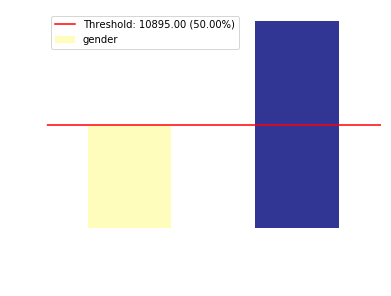

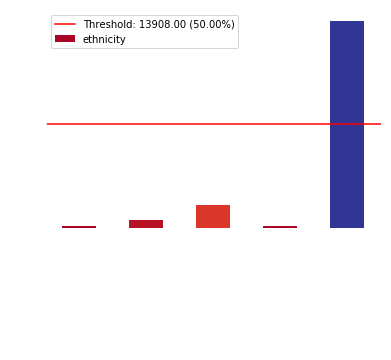

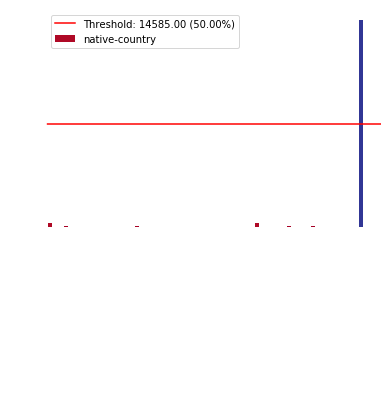

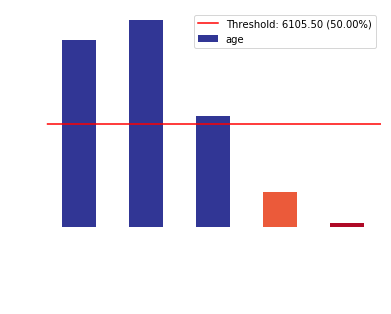

In [786]:
ims = xai.show_imbalances(df, protected)

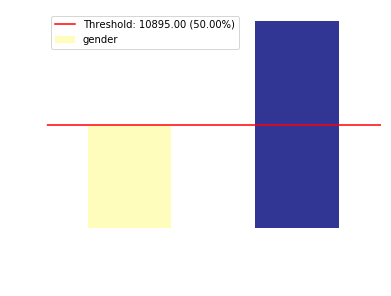

In [787]:
im = xai.show_imbalance(df, "gender")

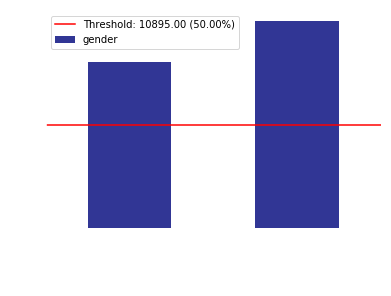

In [788]:
bal_df = xai.balance(df, "gender", upsample=0.8)

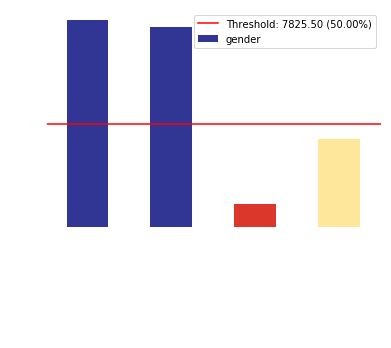

In [789]:
im = xai.show_imbalance(bal_df, "gender", cross=["loan"])

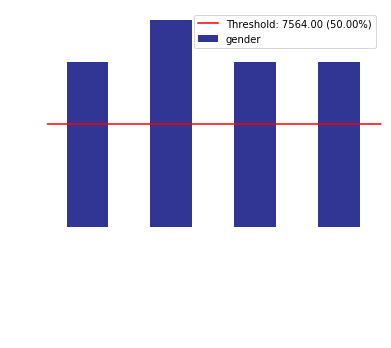

In [790]:
bal_df = xai.balance(df, "gender", cross=["loan"], upsample=0.8)

In [792]:
from sklearn.model_selection import train_test_split

proc_df = xai.normalize_numeric(df)
proc_df = xai.convert_categories(proc_df)
x = proc_df.drop("loan", axis=1)
y = proc_df["loan"]

x_train, y_train, x_test, y_test = xai.balanced_train_test_split(
            x, y, cross=["gender"], 
            categorical_cols=categorical_cols, min_per_class=100,
            fallback_type="half")


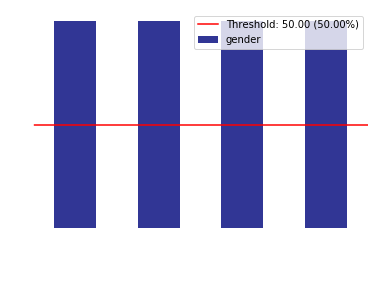

In [793]:
df_test = x_test.copy()
df_test["loan"] = y_test

_= xai.show_imbalance(df_test, "gender", cross=["loan"], categorical_cols=categorical_cols)

In [794]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc

from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding

def build_model(X):
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(X[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model


def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs, threshold=0.5):
    """Convert probabilities into classes"""
    return list((probs >= threshold).astype(int).T[0])


In [795]:
model = build_model(proc_df.drop("loan", axis=1))

model.fit(f_in(x_train), y_train, epochs=50, batch_size=512)

Epoch 1/50
32161/32161 [==============================] - 2s 58us/step - loss: 0.5165 - acc: 0.7675
Epoch 2/50
32161/32161 [==============================] - 0s 5us/step - loss: 0.4067 - acc: 0.8155
Epoch 3/50
32161/32161 [==============================] - 0s 5us/step - loss: 0.3579 - acc: 0.8373
Epoch 4/50
32161/32161 [==============================] - 0s 5us/step - loss: 0.3311 - acc: 0.8457
Epoch 5/50
32161/32161 [==============================] - 0s 5us/step - loss: 0.3222 - acc: 0.8485
Epoch 6/50
32161/32161 [==============================] - 0s 5us/step - loss: 0.3179 - acc: 0.8535
Epoch 7/50
32161/32161 [==============================] - 0s 5us/step - loss: 0.3157 - acc: 0.8539
Epoch 8/50
32161/32161 [==============================] - 0s 6us/step - loss: 0.3142 - acc: 0.8553
Epoch 9/50
32161/32161 [==============================] - 0s 6us/step - loss: 0.3134 - acc: 0.8551
Epoch 10/50
32161/32161 [==============================] - 0s 6us/step - loss: 0.3127 - acc: 0.8556
Epoch 11

In [796]:
probabilities = model.predict(f_in(x_test))
pred = f_out(probabilities)

../xai/__init__.py:338: RuntimeWarning: invalid value encountered in long_scalars
  specificity = TN / (TN+FP)
../xai/__init__.py:336: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP+FP)
../xai/__init__.py:337: RuntimeWarning: invalid value encountered in long_scalars
  recall = TP / (TP+FN)
../xai/__init__.py:338: RuntimeWarning: invalid value encountered in long_scalars
  specificity = TN / (TN+FP)


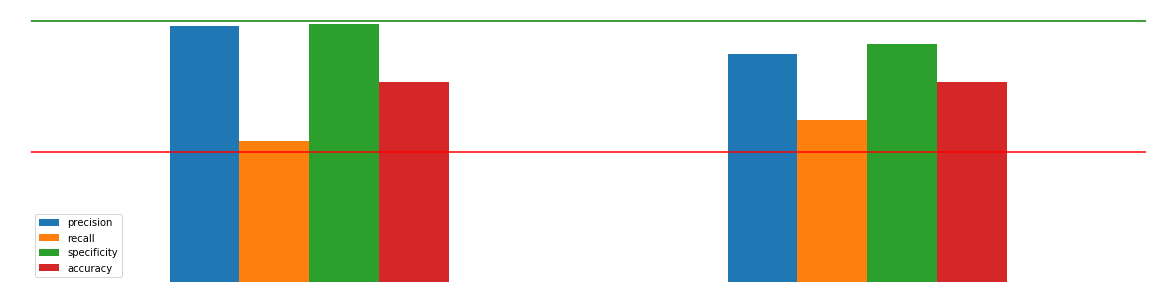

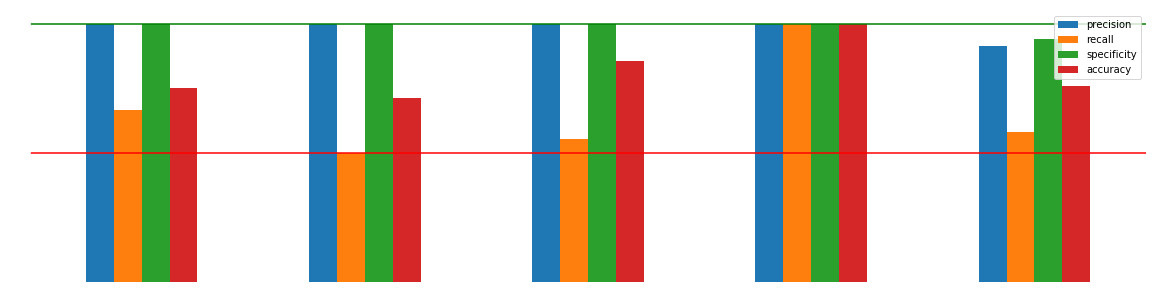

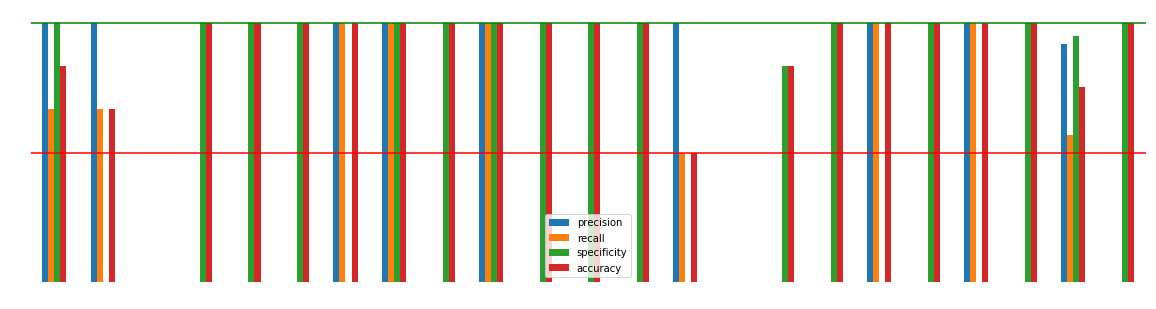

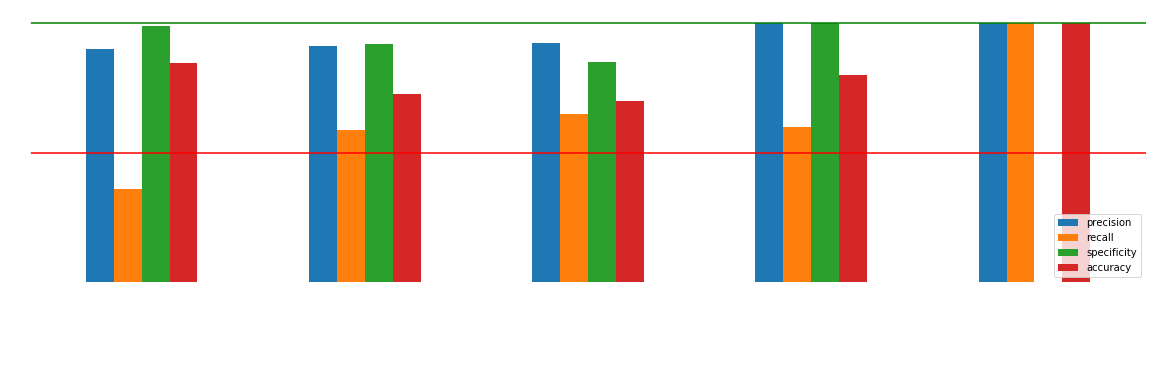

In [797]:
_= xai.metrics_imbalances(
        x_test, 
        y_test, 
        probabilities,
        columns=protected,
        categorical_cols=categorical_cols)

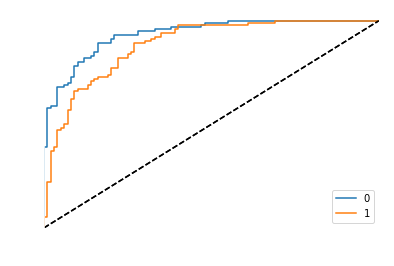

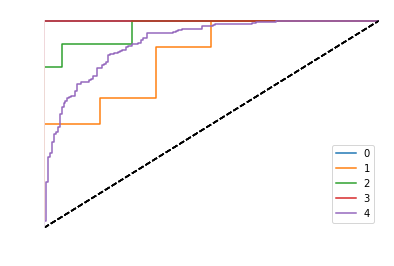

/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


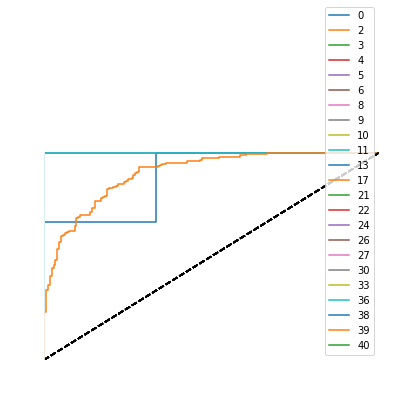

/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


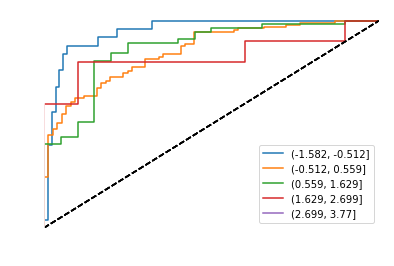

In [806]:
_= xai.roc_imbalances(
    x_test, 
    y_test, 
    probabilities, 
    columns=protected,
    categorical_cols=categorical_cols)

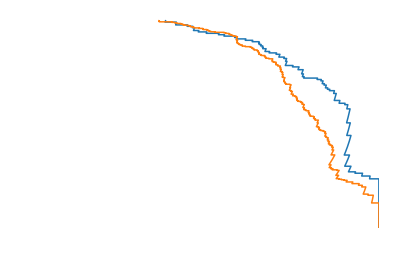

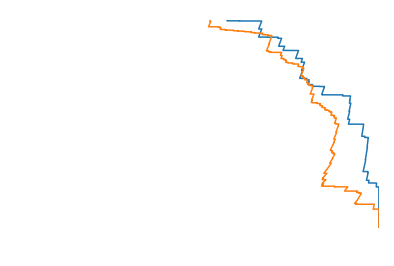

In [598]:
from sklearn.metrics import precision_recall_curve

def multi_pr(
        x_df, 
        y_valid, 
        y_pred, 
        c, 
        bins=6, 
        average=None,
        categorical_cols=None):
    
    x_tmp = x_df.copy()
    x_tmp["target"] = y_valid
    x_tmp["predicted"] = y_pred
    if not average:
        # TODO: Enable for multiclass multidisplay
        average = "binary" if len(np.unique(y_valid)) == 2 else "weighted"
    grouped = xai.group_by_columns(
        x_tmp, 
        [c], 
        bins=bins, 
        categorical_cols=categorical_cols) 
    prfs = []
    classes = []
    
    fprs = []
    tprs = []
    
    plt.figure()
    
    for group, group_df in grouped:
        group_valid = group_df["target"]
        group_pred = group_df["predicted"]
        
        fpr, tpr, _ = precision_recall_curve(group_valid, group_pred)
        fprs.append(fpr)
        tprs.append(tpr)
    
        plt.plot(fpr, tpr, label=group)
        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
#     plt.legend(loc="lower left")
    plt.rcParams.update(params)
    plt.show()
    
# for col in protected: 
#     multi_pr(
#         x_test, 
#         y_test, 
#         probabilities, 
#         col, 
#         categorical_cols=categorical_cols)

multi_pr(
    x_test, 
    y_test, 
    probabilities, 
    "gender", 
    categorical_cols=categorical_cols)
multi_pr(
    x_test_long, 
    y_test_long, 
    probs_long, 
    "gender", 
    categorical_cols=categorical_cols)